In [1]:
pip install opencv-python-headless numpy matplotlib scikit-learn scipy imageio


### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details: 
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

Number of frames loaded: 80


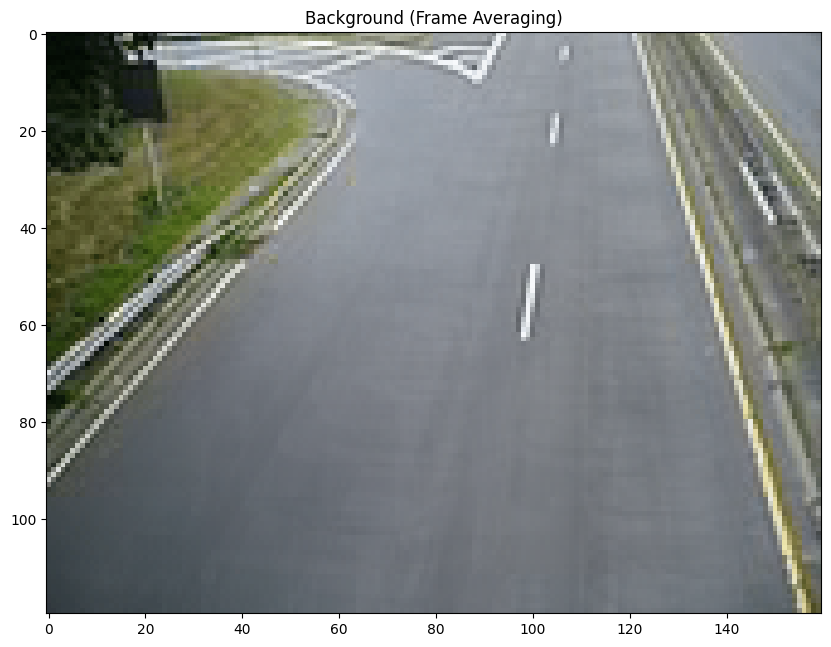

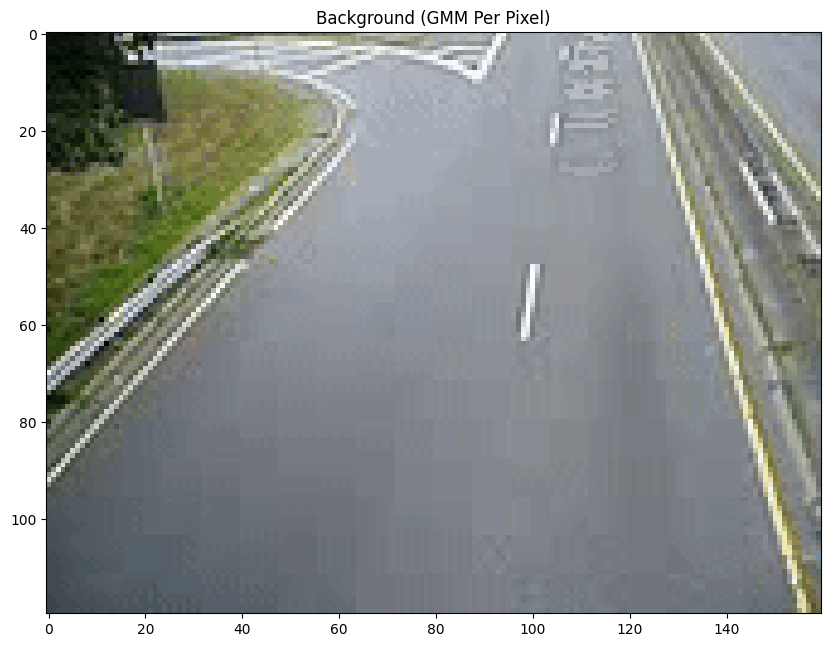

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import glob
import imageio

# GMM Implementation
class GMM:
    def __init__(self, n_components=2, tol=1e-4, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.mu = None
        self.sigma = None
        self.phi = None
        self.weights = None

    def initialize(self, X):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_samples, self.n_components))
        effective_n_components = min(self.n_components, len(np.unique(X, axis=0)))
        if effective_n_components < self.n_components:
            self.n_components = effective_n_components
        try:
            kmeans = KMeans(n_clusters=self.n_components, n_init=10)
            labels = kmeans.fit_predict(X)
            self.mu = kmeans.cluster_centers_
            unique_labels = np.unique(labels)
            self.phi = np.bincount(labels, minlength=self.n_components) / len(X)
            self.sigma = [np.cov(X[labels == i].T) if np.sum(labels == i) > 1 else np.eye(n_features) * 1e-6 for i in unique_labels]
        except ValueError as e:
            print(f"Error during KMeans initialization: {e}")
            self.handle_low_variance_case(X)

    def handle_low_variance_case(self, X):
        n_features = X.shape[1]
        self.mu = np.mean(X, axis=0, keepdims=True)
        self.sigma = [np.eye(n_features) * 1e-6]
        self.phi = [1.]
        self.weights = np.ones((X.shape[0], 1))

    def e_step(self, X):
        likelihood = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            reg_cov = self.sigma[i] + np.eye(self.sigma[i].shape[0]) * 1e-6
            likelihood[:, i] = multivariate_normal(mean=self.mu[i], cov=reg_cov, allow_singular=True).pdf(X)
        total_likelihood = np.sum(likelihood, axis=1, keepdims=True)
        self.weights = likelihood / np.maximum(total_likelihood, 1e-6)

    def m_step(self, X):
        eps = 1e-6
        n_samples, n_features = X.shape
        for i in range(self.n_components):
            weight = self.weights[:, i] + eps
            total_weight = weight.sum()
            self.mu[i] = np.sum(X * weight[:, np.newaxis], axis=0) / total_weight
            diff = X - self.mu[i]
            self.sigma[i] = np.dot(diff.T * weight, diff) / total_weight + np.eye(n_features) * eps
            self.phi[i] = total_weight / n_samples

    def fit(self, X):
        self.initialize(X)
        for _ in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

    def predict(self, X):
        self.e_step(X)
        return np.argmax(self.weights, axis=1)

# Function to extract frames from a video file
def extract_frames(video_path, frames_folder):
    if not os.path.exists(frames_folder):
        os.makedirs(frames_folder)
    cap = cv2.VideoCapture(video_path)
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(frames_folder, f'frame_{count:04d}.png')
        cv2.imwrite(frame_path, frame)
        count += 1
    cap.release()
    cv2.destroyAllWindows()

# Setup video processing
video_name = 'traffic.gif'  # Update this path to your video file
source_path = os.path.join('/content/videos', video_name)  # Update this path
frames_folder = '/content/frames'

# Extract frames from the video
extract_frames(source_path, frames_folder)

# Load frames and preprocess
frames = []
for file_path in sorted(glob.glob(f"{frames_folder}/*.png")):
    img = cv2.imread(file_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frames.append(img)
frames = np.array(frames)

if frames.size == 0:
    print("No frames loaded.")
else:
    print(f"Number of frames loaded: {frames.shape[0]}")

# Frame Averaging for Background Subtraction
background_average = np.mean(frames, axis=0).astype(np.uint8)

# Display the background (Frame Averaging)
plt.figure(figsize=(10, 8))
plt.imshow(background_average)
plt.title("Background (Frame Averaging)")
plt.show()

# GMM Per Pixel for Background Extraction
def fit_gmm_per_pixel(frames, n_components=2):
    height, width, _ = frames[0].shape
    background_model = np.zeros((height, width, 3), dtype=np.float32)
    for i in range(height):
        for j in range(width):
            pixel_series = frames[:, i, j, :].reshape(-1, 3)
            gmm = GMM(n_components=n_components)
            gmm.fit(pixel_series)
            bg_component = np.argmax(gmm.phi)
            background_model[i, j, :] = gmm.mu[bg_component]
    return background_model.astype(np.uint8)

# Fit GMM per pixel and predict background model
background_gmm = fit_gmm_per_pixel(frames[:10])  # Using a subset of frames for speed

# Display the GMM-based background
plt.figure(figsize=(10, 8))
plt.imshow(background_gmm)
plt.title("Background (GMM Per Pixel)")
plt.show()



In [3]:
import cv2
import numpy as np
import os
import glob

# Assuming the background_gmm and frames have been prepared by your earlier code

# Foreground Extraction Function
def extract_foreground(frames, background):
    foreground_frames = []
    for frame in frames:
        # Compute the absolute difference in grayscale for mask, but keep original frames in color
        foreground_mask = cv2.absdiff(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), cv2.cvtColor(background, cv2.COLOR_RGB2GRAY))
        _, foreground_mask = cv2.threshold(foreground_mask, 30, 255, cv2.THRESH_BINARY)

        # Create a 3-channel mask to apply on the color image
        foreground_mask_3ch = cv2.cvtColor(foreground_mask, cv2.COLOR_GRAY2BGR)

        # Apply the mask to the original, colored frame to retain color in the foreground
        colored_foreground = cv2.bitwise_and(frame, foreground_mask_3ch)
        foreground_frames.append(colored_foreground)
    return foreground_frames

# Choose a background model
background_model = background_gmm  # Assuming background_gmm is the background model you've created

# Extract foreground frames
foreground_frames = extract_foreground(frames, background_model)

# Function to save frames as a video
def save_frames_as_video(frames, output_path='./results/foreground_video_gmm.mp4', fps=10):
    if not os.path.exists('./results'):
        os.makedirs('./results')
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

    for frame in frames:
        video.write(frame)
    video.release()

# Save foreground frames as a color video
save_frames_as_video(foreground_frames, './results/foreground_video_gmm.mp4', fps=10)

background_model = background_average # Assuming background_gmm is the background model you've created

# Extract foreground frames
foreground_frames = extract_foreground(frames, background_model)

# Function to save frames as a video
def save_frames_as_video(frames, output_path='./results/foreground_video_avg.mp4', fps=10):
    if not os.path.exists('./results'):
        os.makedirs('./results')
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

    for frame in frames:
        video.write(frame)
    video.release()

# Save foreground frames as a color video
save_frames_as_video(foreground_frames, './results/foreground_video_avg.mp4', fps=10)

print("Foreground video saved successfully.")


Foreground video saved successfully.


In [7]:
from IPython.display import Video
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

def extract_and_display_video(frames, fps=30):
    """
    Create and display a video from a list of frames.
    """
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_videofile("output.mp4")
    return Video("output.mp4", embed=True)

def extract_frames(video_path):
    """
    Extract frames from a video file.
    """
    frames = []
    clip = VideoFileClip(video_path)
    for frame in clip.iter_frames():
        frames.append(frame)
    return frames
print("GMM Result")
# Path to your saved video file
video_path = '/content/results/foreground_video_gmm.mp4'

# Extract frames from the video file
frames = extract_frames(video_path)

extract_and_display_video(frames)


GMM Result
Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [6]:
# Call the function to display the video
extract_and_display_video(frames)

print("Frame Avg. Result")

# Path to your saved video file
video_path = '/content/results/foreground_video_gmm.mp4'

# Extract frames from the video file
frames = extract_frames(video_path)

# Call the function to display the video
extract_and_display_video(frames)

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
Frame Avg. Result
Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
